In [1]:
import numpy as np
import pandas as pd

from covidboosters import IndividualSusceptibilityModel, OutbreakRiskModel
from scripts.default_parameters import DEFAULT_PARAMETERS

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.ioff()
rc_params = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.autolayout": True,
    "axes.autolimit_mode": "round_numbers",
    "savefig.transparent": True,
    "savefig.format": "pdf",
    "svg.fonttype": "none",
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
}
sns.set_theme(style="ticks", rc=rc_params)

In [3]:
rng = np.random.default_rng(0)

In [4]:
period = DEFAULT_PARAMETERS["period"]
unvaccinated_reproduction_no_mean = DEFAULT_PARAMETERS[
    "unvaccinated_reproduction_no_mean"
]
unvaccinated_reproduction_no_prop_variation = DEFAULT_PARAMETERS[
    "unvaccinated_reproduction_no_prop_variation"
]
peak_transmission_time = DEFAULT_PARAMETERS["peak_transmission_time"]
dispersion_param = DEFAULT_PARAMETERS["dispersion_param"]
generation_time_dist = DEFAULT_PARAMETERS["generation_time_dist"]
proportion_vaccinated = DEFAULT_PARAMETERS["proportion_vaccinated"]
population_size = DEFAULT_PARAMETERS["population_size"]
antibody_model_params_pop = DEFAULT_PARAMETERS["antibody_model_params_pop"]
antibody_model_params_random_effects = DEFAULT_PARAMETERS[
    "antibody_model_params_random_effects"
]
susceptibility_func_params = DEFAULT_PARAMETERS["susceptibility_func_params"]

In [5]:
outbreak_risk_model_kwargs = {
    "period": period,
    "unvaccinated_reproduction_no_mean": unvaccinated_reproduction_no_mean,
    "unvaccinated_reproduction_no_prop_variation": unvaccinated_reproduction_no_prop_variation,
    "peak_transmission_time": peak_transmission_time,
    "generation_time_dist": generation_time_dist,
    "dispersion_param": dispersion_param,
    "proportion_vaccinated": proportion_vaccinated,
    "antibody_model_params_pop": antibody_model_params_pop,
    "antibody_model_params_random_effects": antibody_model_params_random_effects,
    "susceptibility_func_params": susceptibility_func_params,
    "population_size": population_size,
    "rng": rng,
}

In [18]:
month_starts = np.arange(0, period + 1, period // 12)
month_list = ["Jan", "", "", "Apr", "", "", "Jul", "", "", "Oct", "", "", "Jan"]

In [7]:
vaccination_start_time_vals = np.arange(0, period + 1, 5)
vaccination_duration_vals = np.arange(5, period + 1, 5)

In [8]:
max_cor_df = (
    pd.DataFrame(
        index=vaccination_start_time_vals,
        columns=vaccination_duration_vals,
        dtype=float,
    )
    .rename_axis("Start of campaign", axis=0)
    .rename_axis("Duration of campaign (days)", axis=1)
)
for i, vaccination_start_time in enumerate(vaccination_start_time_vals):
    for j, vaccination_duration in enumerate(vaccination_duration_vals):
        vaccination_time_range = (
            vaccination_start_time,
            vaccination_start_time + vaccination_duration,
        )
        outbreak_risk_model = OutbreakRiskModel(
            vaccination_time_range=vaccination_time_range, **outbreak_risk_model_kwargs
        )
        max_cor_curr = np.max(outbreak_risk_model.case_outbreak_risk(np.arange(period)))
        max_cor_df.loc[vaccination_start_time, vaccination_duration] = max_cor_curr

/Users/user/Documents/Git_repos/covid-boosters/covidboosters/base.py:508: RuntimeWarning: invalid value encountered in power
  - (


In [26]:
start_time_best, duration_best = max_cor_df.stack().idxmin()
vaccination_time_range_best = (
    start_time_best,
    start_time_best + duration_best,
)
vaccination_time_range_best
max_cor_df.loc[start_time_best, duration_best]

0.1759008007955789

In [1]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2.45)
ax = fig.add_subplot(box_aspect=1)
sns.heatmap(
    max_cor_df.transpose(),
    cbar=True,
    ax=ax,
    rasterized=True,
    cmap="viridis",
    cbar_kws={"label": "Maximum outbreak risk"},
)
ax.invert_yaxis()
ax.plot(
    np.where(vaccination_start_time_vals == start_time_best)[0],
    np.where(vaccination_duration_vals == duration_best)[0],
    "wo",
)
ax.set_xticks(month_starts // 5, labels=month_list)
ax.set_yticks(month_starts // 5, labels=month_starts)
# ax.set_xlabel("Start time of vaccination campaign")
# ax.set_ylabel("Duration of vaccination campaign")
plt.savefig("figures_initial/optimising_vaccination/heatmap.pdf")
plt.show()

NameError: name 'plt' is not defined

In [11]:
time_vec = np.arange(2 * period)
outbreak_risk_model_best = OutbreakRiskModel(
    vaccination_time_range=vaccination_time_range_best, **outbreak_risk_model_kwargs
)
cor_vec_best = outbreak_risk_model_best.case_outbreak_risk(time_vec)
outbreak_risk_model_unvacc = OutbreakRiskModel(
    vaccination_time_range=vaccination_time_range_best,
    **{**outbreak_risk_model_kwargs, "proportion_vaccinated": 0},
)
cor_vec_unvacc = outbreak_risk_model_unvacc.case_outbreak_risk(time_vec)

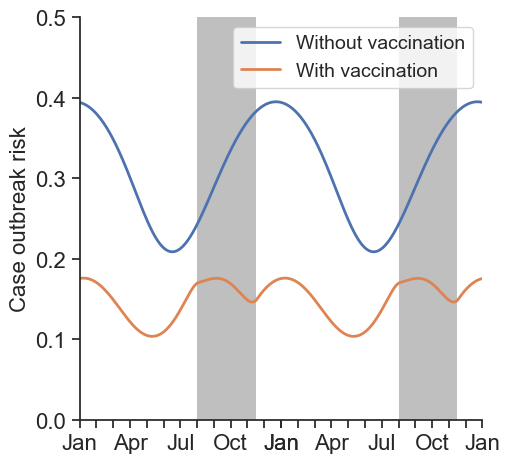

In [24]:
fig = plt.figure()
ax = fig.add_subplot(box_aspect=1)
ax.plot(time_vec, cor_vec_unvacc, label="Without vaccination")
ax.plot(time_vec, cor_vec_best, label="With vaccination")
ax.set_xlim(0, 2 * period)
ax.set_xticks(
    np.append(month_starts, month_starts + period),
    labels=month_list + month_list,
)
ax.set_ylim(0, 0.5)
ax.fill_betweenx(
    y=[0, 1],
    x1=vaccination_time_range_best[0],
    x2=vaccination_time_range_best[1],
    color="gray",
    alpha=0.5,
    linewidth=0,
)
ax.fill_betweenx(
    y=[0, 1],
    x1=period + vaccination_time_range_best[0],
    x2=period + vaccination_time_range_best[1],
    color="gray",
    alpha=0.5,
    linewidth=0,
)
ax.set_ylabel("Case outbreak risk")
ax.legend()
plt.savefig("figures_initial/optimising_vaccination/outbreak_risk_best.pdf")
plt.show()